# Lab 5: Resampling and the Bootstrap

Welcome to Lab 5!

We will attempt to estimate the number `N`, a *population parameter*, that represents the number of elements in a population. We get to observe a uniform random sample of the elements, and for each one we can observe its serial number (from 1 to `N`). All elements are labeled with consecutive serial numbers from 1 to `N`, so `N` is the total number of elements. 

Given *just* a random sample of elements, we'll estimate `N`, and then we'll use simulation to find a confidence interval around our estimate, all without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [1]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', UserWarning)

# Don't change this cell; just run it. 
#from okgrade import grade

## 1. Preliminaries
The setup: We want to know the number of elements in the population.  That number is `N`.  Each element is numbered from 1 to `N`.

We only see a small number of elements (assumed to be a uniform random sample with replacement from among all the elements), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?

N is a statistic (population sample).
The estimate of N is also a statistic.

Check your answer by posting on the discussion forum.

To make the situation realistic, we're going to hide the true number of elements from you.  You'll have access only to this random sample:

In [3]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
Define a function named `plot_serial_numbers` to make a histogram of any table of serial numbers.  It should take one argument, a table like `observations` with one column called `"serial number"`.  It should plot a histogram of the values in the column **using bins of width 1** ranging from **1 to 200** but return nothing.  Then, call that function to make a histogram of `observations`.

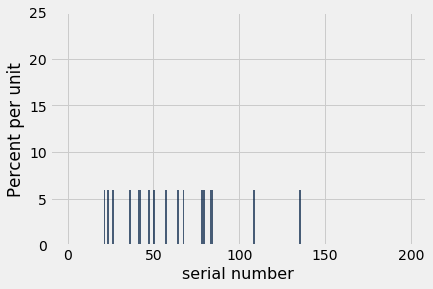

In [5]:
def plot_serial_numbers(numbers):
    numbers.hist('serial number',bins=(np.arange(200)))
    
    # Assuming the lines above produce a histogram, this next
    # line may make your histograms look nicer.  Feel free to
    # delete it if you want.
    plt.ylim(0, .25)

plot_serial_numbers(observations)

#### Question 1.3
By looking at the histogram, what can we say about `N` immediately? (Hint: What is the relationship between `N` and the largest serial number in `observations`?) What does each little bar in the histogram represent? Why are all the bars the same height?

N is a number (serial number), which means that is is discrete. One can consider N the largest serial number in the set, but the reason why each column in the histogram is the same height is because there is only one of the serial unit/(size of set). So, if each number is roughly 6%, then it follows that 6% of the population has a serial number of 50 for example (1/17 ~ 6%).

#### Question 1.4
One way to estimate `N` is to take twice the mean of the serial numbers we observe. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call it `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

In [6]:
def mean_based_estimator(nums):
    ExpectedValueNums=np.mean(nums)
    N=ExpectedValueNums*2
    return N

mean_based_estimate = mean_based_estimator(observations.column(0))
mean_based_estimate

122.47058823529412

In [7]:
#grade('tests/q1_4.py')

#### Question 1.5
We can also estimate `N` using the biggest serial number in the sample.  Compute it, giving it the name `max_estimate`.

In [8]:
max_estimate = observations.column(0).max()
max_estimate

135

In [9]:
#grade('tests/q1_5.py')

#### Question 1.6
Look at the values of `max_estimate` and `mean_based_estimate` that we happened to get for our dataset.  The value of `max_estimate` tells you something about `mean_based_estimate`.  For these specific values, is it possible for our value  of `mean_based_estimate` to be equal to `N` (at least, if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Can you make a statement like the value of our "`mean_based_estimate` is at least *[fill in a number]* away from `N`"?

The mean based estimate will always be lower than N assuming that an N of 135 implies that 135 have been made. Considering the skew of the histogram is to the left of the mean, this means that we see a majority of the data that we do have is below the max. If they for example had right skewed the numbers, that is , 135=75 have been made, it's possible, but still not enough data is present to be conclusive.

Check your answer by posting on the discussion forum.

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate new observations.  Rather we sample from our current sample, or "resample" the data.

Why does that make any sense?

When we tried to estimate `N`, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to *run a simulation* about estimates of `N`.  But we still only have our sample.  We use our sample in place of the population to run the simulation.

So there is a simple analogy between estimating `N` and simulating the variability of estimates.

$$\text{computing }N\text{ from the population}$$
$$:$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$:$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be a table like `observations`.)  It should take no arguments.

In [10]:
def simulate_resample():
    Resample=observations.sample(k=observations.num_rows,with_replacement=True)
    return Resample

Let's make one resample.

In [11]:
# This line is a little magic to make sure that you see the same results
# we did.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

serial number
108
57
57
36
41
42
47
50
135
47


In [12]:
#grade('tests/q2_1.py')

Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

#### Question 2.2
In preparation for answering the next question, generate a histogram of your resample using the plotting function you defined earlier in this lab, **and** generate a separate histogram of the original observations.

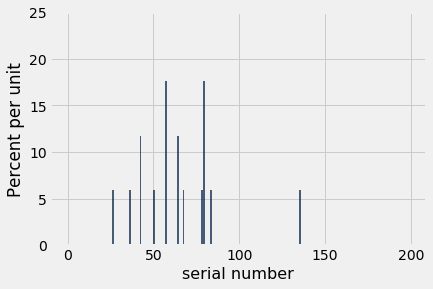

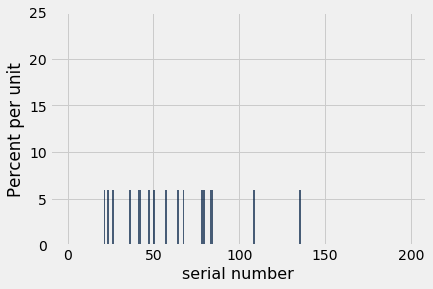

In [13]:
plot_serial_numbers(simulate_resample())
plot_serial_numbers(observations)

#### Question 2.3
Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. The resample has exactly one copy of each serial number.
4. The sample has exactly one copy of each serial number.

Assign true_statements to a list of the correct statements.

In [21]:
true_statements = [1, 4] #Only statements 1 and 4 are true.

In [22]:
#grade('tests/q2_3.py')

#### Question 2.4
Create two more resamples using the function `simulate_resample` from above. For each resampled data, plot it and compute its max- and mean-based estimates.

Mean-based estimate for resample 0: 53.411764705882355
Max-based estimate for resample 0: 108
Mean-based estimate for resample 1: 63.1764705882353
Max-based estimate for resample 1: 135


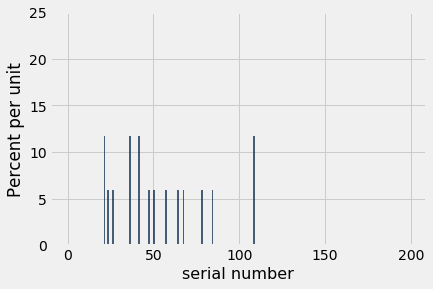

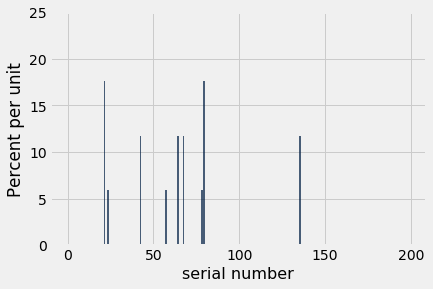

In [23]:
resample_0 = simulate_resample()
plot_serial_numbers(resample_0)
mean_based_estimate_0 = np.mean(resample_0.column(0))
max_based_estimate_0 = resample_0.column(0).max()
print("Mean-based estimate for resample 0:", mean_based_estimate_0)
print("Max-based estimate for resample 0:", max_based_estimate_0)

resample_1 = simulate_resample()
plot_serial_numbers(resample_1)
mean_based_estimate_1 = np.mean(resample_1.column(0))
max_based_estimate_1 = resample_1.column(0).max()
print("Mean-based estimate for resample 1:", mean_based_estimate_1)
print("Max-based estimate for resample 1:", max_based_estimate_1)

You may find that the max-based estimates from the resamples are both exactly 135.  You will probably find that the two mean-based estimates do differ from the sample mean-based estimate (and from each other).

#### Question 2.5
Using probability that you've learned, compute the exact chance that a max-based estimate from *one* resample is 135.

Using your intuition, explain why a mean-based estimate from a resample is less often exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

As a refresher, here are some rules of probability that may be helpful:

- When all outcomes are equally likely: P(event happens) $=$ $\frac{\text{# outcomes that make event happen}}{\text{# of all outcomes}}$

- When an event can happen in 2 ways: P(event) $=$ P(event happening first way) $+$ P(event happening second way)

- When 2 events must both happen: P(2 events both happen) $=$ P(one event happens) $*$ P(other event happens, given the first one happened)

- When an event doesn't happen: P(event doesn't happen) $=$ 1 $-$ P(event does happen)

- P(at least one success) $= 1 - $ P(no successes)

For computing the exact chance a max based estimate from one sample is 135: Let's consider that for one resample, we've equally sampled from the population 17 times (the number of samples in the population). The probability of 135 appearing is 1/17. Conversely, the probability of 135 not appearing is $1-1/17=16/17$. So, the probability of 135 not appearing after 17 trials is $(16/17)^{17}$. Therefore, to negate again, the probability of it appearing after 17 trials is: $P(135 \text{is maxed based estimate})=1- (16/17)^{17}$.

In [24]:
P135max=1.-(16/17)**17
P135max

0.6432138052537073

The mean based estimate from the resample is usually fairly close, but less than the mean from the original because 135 is the outliar. That is, there is a 64% chance that the mean will be skewed to the right in the resample, and therefore, a roughly 35% the resample mean will always be less than the original mean.

Assuming we do a simulation which is what's doing to happen below, let's assuming that we've sampled 1000 times. Now, our probability of 135 is $P(135)=\frac{\text{(quantity of 135's sampled)}}{\text{(1000 samples)}}$

Discuss your answers on the edX discussion forums.  If you have difficulty with the probability calculation, ask for help; don't stay stuck on it for too long.

## 3. Simulating with resampling

**Note**: *The last part of this lab is difficult to check automatically, so it will not be graded. We strongly suggest that you try to complete it. We will release solutions to this lab so that you can compare to them.*

Since resampling from a sample is very similar to sampling from a population, the code should look almost the same.  That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

#### Question 3.1
Write a function called `simulate_estimates`.  It should take 4 arguments:
1. A table from which the data should be sampled.  The table will have 1 column named `"serial number"`.
2. The size of each sample from that table, an integer.  (For example, to do resampling, we would pass for this argument the number of rows in the table.)
3. A function that computes a statistic of a sample.  This argument is a *function* that takes an array of serial numbers as its argument and returns a number.
4. The number of replications to perform.

It should simulate many samples with replacement from the given table.  (The number of samples is the 4th argument.)  For each of those samples, it should compute the statistic on that sample. Then it should return an array containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

**Hint**: Your implementation should contain the following line, which extracts the "serial number" column from some table ``t`` and calls the `statistic` function on it, storing the result in the name `s`.

``s = statistic(t.column("serial number"))``

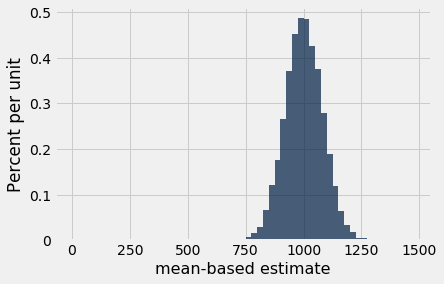

In [26]:
def simulate_estimates(original_table, sample_size, statistic, num_replications):
    # Our implementation of this function took 5 short lines of code.
    t=Table().with_column('serial number',[])
    s=[]
    for i in np.arange(num_replications):
        Sample=np.random.choice(original_table.column(0),replace=True,size=sample_size)
        t=Table().with_column('serial number',Sample)
        s=np.append(s,statistic(t.column(0)))
    return s

# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = simulate_estimates(
    Table().with_column("serial number", np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

In [27]:
example_estimates

array([ 985.  , 1042.84, 1049.  , ..., 1058.48,  963.16, 1196.88])

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 3.2
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5,000 replications.  
We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

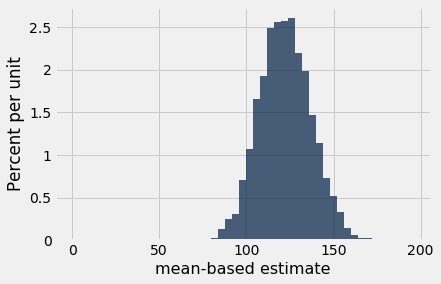

In [28]:
bootstrap_estimates = simulate_estimates(original_table=observations,sample_size=observations.num_rows,num_replications=5000,
                                         statistic=mean_based_estimator)
Table().with_column("mean-based estimate", bootstrap_estimates).hist(bins=np.arange(0, 200, 4))

#### Question 3.3
Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.

In [29]:
left_end = np.percentile(bootstrap_estimates,5)
right_end = np.percentile(bootstrap_estimates,95)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [98.941176, 147.058824]


#### Question 3.4
Your mean-based estimate of `N` should have been around 122. Given the above calculations, is it likely that `N` is exactly 122? If not, what is the typical range of values of the mean-based estimates of `N` for samples of size 17?

It is fairly likely that N is about 122. Our calculation below demonstrates our mean is 122.9. We conclude that the typical range, range between 100 and 148 based off of 95% of the estimates.

In [31]:
np.mean(bootstrap_estimates)

122.40225882352942

Check your solutions with someone on the edX discussion forums

#### Question 3.5
`N` was actually 150!  Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations by sampling from the population table we have created for you below. 
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 5,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

In [32]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(k=population.num_rows,with_replacement=True)
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = simulate_estimates(original_table=new_observations,num_replications=5000,
                                             statistic=mean_based_estimator,sample_size=population.num_rows)
new_left_end = np.percentile(new_bootstrap_estimates,5)
new_right_end = np.percentile(new_bootstrap_estimates,95)

print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

New mean-based estimate: 137.946667
Middle 95% of bootstrap estimates: [126.453333, 149.215333]


#### Question 3.6
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell many times, what is the probability that it will include `N`?

In [33]:
np.mean(new_bootstrap_estimates)

137.8369813333333

Check your solutions with someone on the edX discussion forums

## Submission

Conratulations! You're finished with lab 5 and Data 8.2x! In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.

In [34]:
# For your convenience, you can run this cell to run all the tests at once!
#import glob
#from okgrade.notebook import grade_notebook
#if not globals().get('__OKGRADE__', False):
#    display(grade_notebook('lab05.ipynb', sorted(glob.glob('tests/q*.py'))))